# Phishing Website Detection

Phishing websites, a prevalent form of social engineering, mimic trusted URLs and webpages to deceive users. This project aims to develop machine learning models using a curated dataset to predict phishing websites. The dataset comprises both phishing and legitimate URLs, from which essential URL and website content features are extracted. The performance of each model is evaluated and compared to determine their effectiveness in detecting phishing websites.

### Load Libriaries

In [1]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    log_loss,
    roc_curve,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

### Import Dataset

In [2]:
# Load dataset
phishing_data = pd.read_csv("data/dataset_phishing.csv")
phishing_data.head()
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier

In [3]:
# make a copy of the data
phishing_df = phishing_data.copy()
phishing_df.tail()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate
11429,http://174.139.46.123/ap/signin?openid.pape.ma...,477,14,1,24,0,1,1,9,0,...,1,1,1,0,-1,0,1,1,0,phishing


In [4]:
# get the info
phishing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [5]:
# know the shape
phishing_df.shape

(11430, 89)

In [6]:
# rename the column 'status' to 'target'
phishing_df = phishing_df.rename(columns={'status': 'target'})
phishing_df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [7]:
# get the value counts of the target
phishing_df["target"].value_counts()

target
legitimate    5715
phishing      5715
Name: count, dtype: int64

In [8]:
# check for missing values
phishing_df.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
target             0
Length: 89, dtype: int64

In [9]:
# Check for duplicates in the DataFrame
num_duplicates = phishing_df.duplicated().sum()

if num_duplicates > 0:
    print(f'There are {num_duplicates} duplicate rows in the DataFrame.')
else:
    print('No duplicates found in the DataFrame.')


No duplicates found in the DataFrame.


In [10]:
# Mapping the categorical values to numeric factors
phishing_df['target'] = phishing_df['target'].replace({'legitimate': 0, 'phishing': 1})

### Feature Selection (Top 30)

In [11]:
# Separate features and target variable
X = phishing_df.drop(columns=['target'])  
y = phishing_df['target']

In [12]:
# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns

# Drop non-numeric columns or perform appropriate preprocessing
X_numeric = X.drop(columns=non_numeric_cols)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your dataset and transform it
normalized_data = scaler.fit_transform(X_numeric)

# Create a DataFrame with the normalized values
normalized_df = pd.DataFrame(normalized_data, columns=X_numeric.columns)


In [13]:
# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit Random Forest classifier to the data
rf_clf.fit(normalized_df, y)

# Print feature importances
feature_importances_rf = pd.DataFrame(rf_clf.feature_importances_,
                                      index = normalized_df.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances_rf.head())

               importance
google_index     0.167270
page_rank        0.103554
nb_hyperlinks    0.085749
web_traffic      0.072705
nb_www           0.036990


In [14]:
# Select the top k features based on importance
select_top_k = SelectFromModel(rf_clf, threshold=-np.inf, max_features=30)
X_selected = select_top_k.fit_transform(normalized_df, y)

# Get selected feature names
selected_feature_names = normalized_df.columns[select_top_k.get_support()]
selected_feature_names

Index(['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_slash',
       'nb_www', 'ratio_digits_url', 'ratio_digits_host', 'length_words_raw',
       'char_repeat', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'nb_hyperlinks',
       'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection',
       'links_in_tags', 'safe_anchor', 'domain_in_title',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')

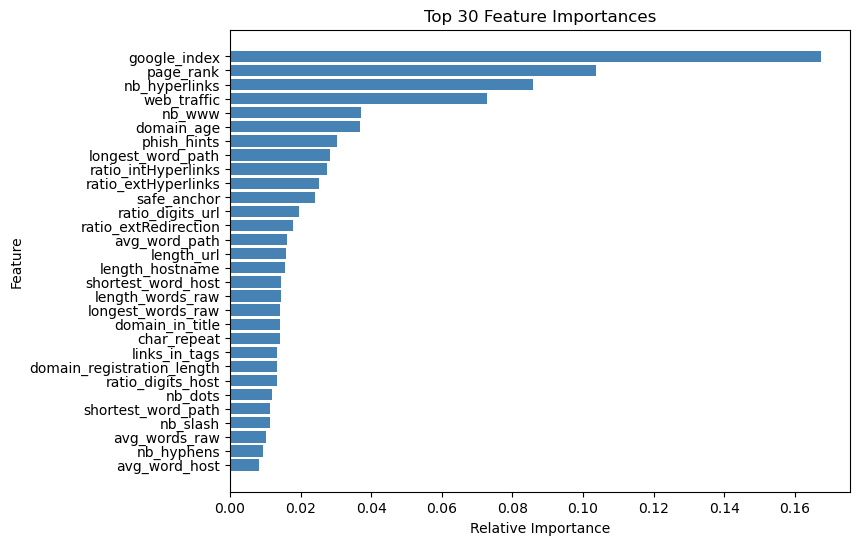

In [15]:
# Sort feature importances in descending order
feature_importances_rf_sorted = feature_importances_rf.head(30)

# Plot feature importances for the top 30 features
plt.figure(figsize=(8, 6))
plt.barh(feature_importances_rf_sorted.index[::-1], feature_importances_rf_sorted['importance'][::-1], color="#4682B4")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances")
plt.show();

In [16]:
# Adding the 'url' and 'target' to the selected features
# Reorder columns to place 'url' first, then 'selected_feature_names', and 'target' last
column_order = ['url'] + selected_feature_names.tolist() + ['target']
phishing_df_new = phishing_df[column_order]

# Display phishing_df_n
phishing_df_new.head()

,url,length_url,length_hostname,nb_dots,nb_hyphens,nb_slash,nb_www,ratio_digits_url,ratio_digits_host,length_words_raw,...,ratio_extRedirection,links_in_tags,safe_anchor,domain_in_title,domain_registration_length,domain_age,web_traffic,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,37,19,3,0,3,1,0.000000,0.0,4,...,0.875000,80.000000,0.0,0,45,-1,0,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,0,5,0,0.220779,0.0,4,...,0.000000,100.000000,100.0,1,77,5767,0,1,2,1
2,https://support-appleld.com.secureupdate.duila...,126,50,4,1,5,0,0.150794,0.0,12,...,0.000000,100.000000,100.0,1,14,4004,5828815,1,0,1
3,http://rgipt.ac.in,18,11,2,0,2,0,0.000000,0.0,1,...,0.250000,100.000000,62.5,1,62,-1,107721,0,3,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,2,2,5,1,0.000000,0.0,6,...,0.537037,76.470588,0.0,0,224,8175,8725,0,6,0


In [17]:
# get the info
phishing_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   nb_dots                     11430 non-null  int64  
 4   nb_hyphens                  11430 non-null  int64  
 5   nb_slash                    11430 non-null  int64  
 6   nb_www                      11430 non-null  int64  
 7   ratio_digits_url            11430 non-null  float64
 8   ratio_digits_host           11430 non-null  float64
 9   length_words_raw            11430 non-null  int64  
 10  char_repeat                 11430 non-null  int64  
 11  shortest_word_host          11430 non-null  int64  
 12  shortest_word_path          11430 non-null  int64  
 13  longest_words_raw           114

In [18]:
phishing_df_new.shape

(11430, 32)

In [19]:
# get the value counts of the target
phishing_df_new["target"].value_counts()

target
0    5715
1    5715
Name: count, dtype: int64

In [20]:
# check for missing values
phishing_df_new.isna().sum()

url                           0
length_url                    0
length_hostname               0
nb_dots                       0
nb_hyphens                    0
nb_slash                      0
nb_www                        0
ratio_digits_url              0
ratio_digits_host             0
length_words_raw              0
char_repeat                   0
shortest_word_host            0
shortest_word_path            0
longest_words_raw             0
longest_word_path             0
avg_words_raw                 0
avg_word_host                 0
avg_word_path                 0
phish_hints                   0
nb_hyperlinks                 0
ratio_intHyperlinks           0
ratio_extHyperlinks           0
ratio_extRedirection          0
links_in_tags                 0
safe_anchor                   0
domain_in_title               0
domain_registration_length    0
domain_age                    0
web_traffic                   0
google_index                  0
page_rank                     0
target  

In [21]:
# Check for duplicates in the DataFrame
num_duplicates = phishing_df_new.duplicated().sum()

if num_duplicates > 0:
    print(f'There are {num_duplicates} duplicate rows in the DataFrame.')
else:
    print('No duplicates found in the DataFrame.')


No duplicates found in the DataFrame.


In [22]:
phishing_df_new.describe()

,length_url,length_hostname,nb_dots,nb_hyphens,nb_slash,nb_www,ratio_digits_url,ratio_digits_host,length_words_raw,char_repeat,...,ratio_extRedirection,links_in_tags,safe_anchor,domain_in_title,domain_registration_length,domain_age,web_traffic,google_index,page_rank,target
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,2.480752,0.997550,4.289589,0.448469,0.053137,0.025024,6.232808,2.927472,...,0.158926,51.978211,37.063922,0.775853,492.532196,4062.543745,8.567566e+05,0.533946,3.185739,0.500000
std,55.297318,10.777171,1.369686,2.087087,1.882251,0.501912,0.089363,0.093422,5.572355,4.768936,...,0.266437,41.523144,39.073385,0.417038,814.769415,3107.784600,1.995606e+06,0.498868,2.536955,0.500022
min,12.000000,4.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,84.000000,972.250000,0.000000e+00,0.000000,1.000000,0.000000
50%,47.000000,19.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,5.000000,3.000000,...,0.000000,60.000000,23.294574,1.000000,242.000000,3993.000000,1.651000e+03,1.000000,3.000000,0.500000
75%,71.000000,24.000000,3.000000,1.000000,5.000000,1.000000,0.079365,0.000000,8.000000,4.000000,...,0.230769,98.061004,75.000000,1.000000,449.000000,7026.750000,3.738455e+05,1.000000,5.000000,1.000000
max,1641.000000,214.000000,24.000000,43.000000,33.000000,2.000000,0.723881,0.800000,106.000000,146.000000,...,2.000000,100.000000,100.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,10.000000,1.000000


## Exploratory Data Analysis (EDA)

In [23]:
# pip install wordcloud
# pip install --upgrade pip

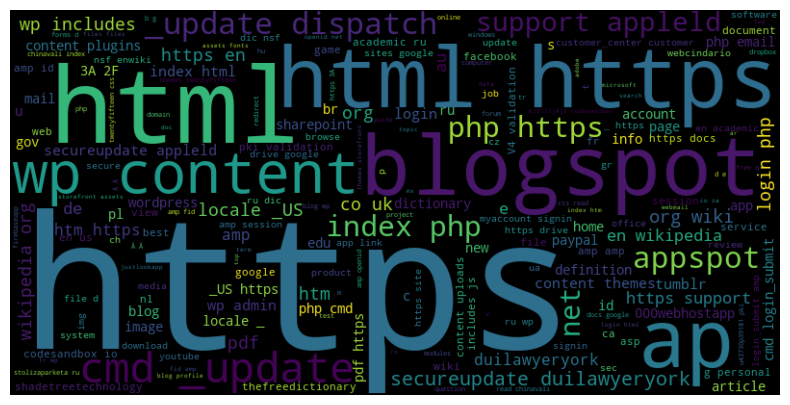

In [24]:
# view frequent words in the url
text = ' '.join(phishing_df_new['url'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

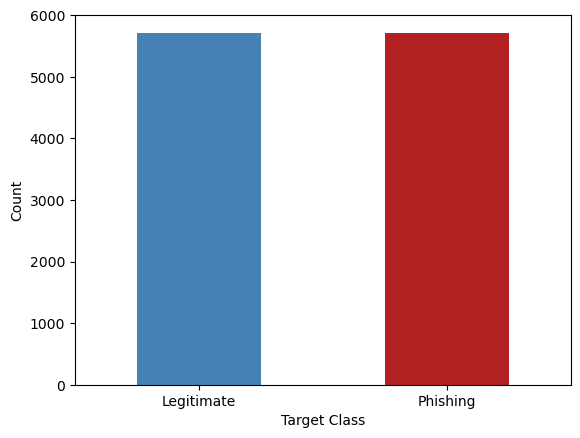

In [25]:
# colors for the target classes
colors = ['#4682B4', '#B22222']

# labels for the target classes
labels = ['Legitimate', 'Phishing']

# Plot the target class counts with colors and labels
phishing_df_new['target'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks([0, 1], labels, rotation=0) 
plt.show()

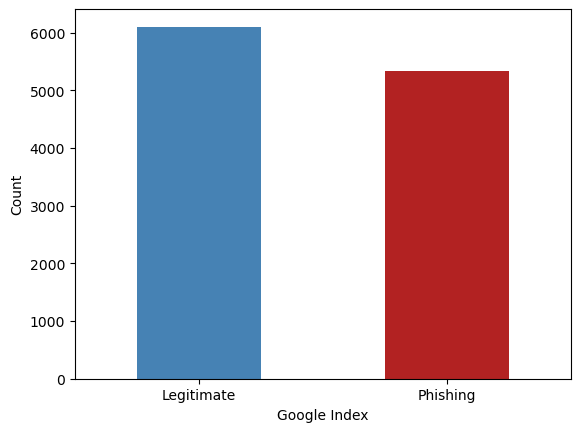

In [26]:
# colors for the google_index
colors = ['#4682B4', '#B22222']

# labels for the google_index
labels = ['Legitimate', 'Phishing']

# Plot the google_index counts with colors and labels
phishing_df_new['google_index'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Google Index')
plt.ylabel('Count')
plt.xticks([0, 1], labels, rotation=0) 
plt.show()

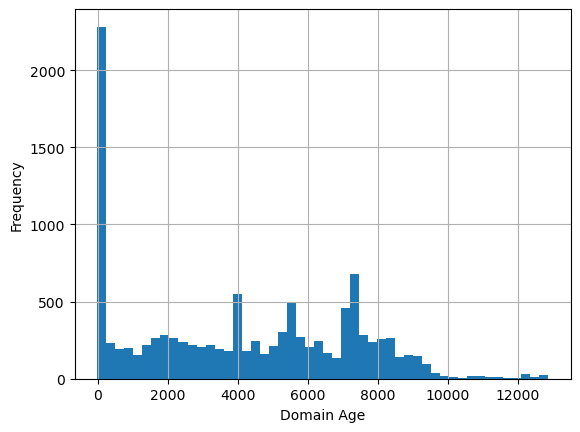

In [27]:
# Plot histogram of domain ages
phishing_df_new['domain_age'].hist(bins=50)

# Set labels for x and y axes
plt.xlabel('Domain Age')
plt.ylabel('Frequency')

# Display the plot
plt.show()

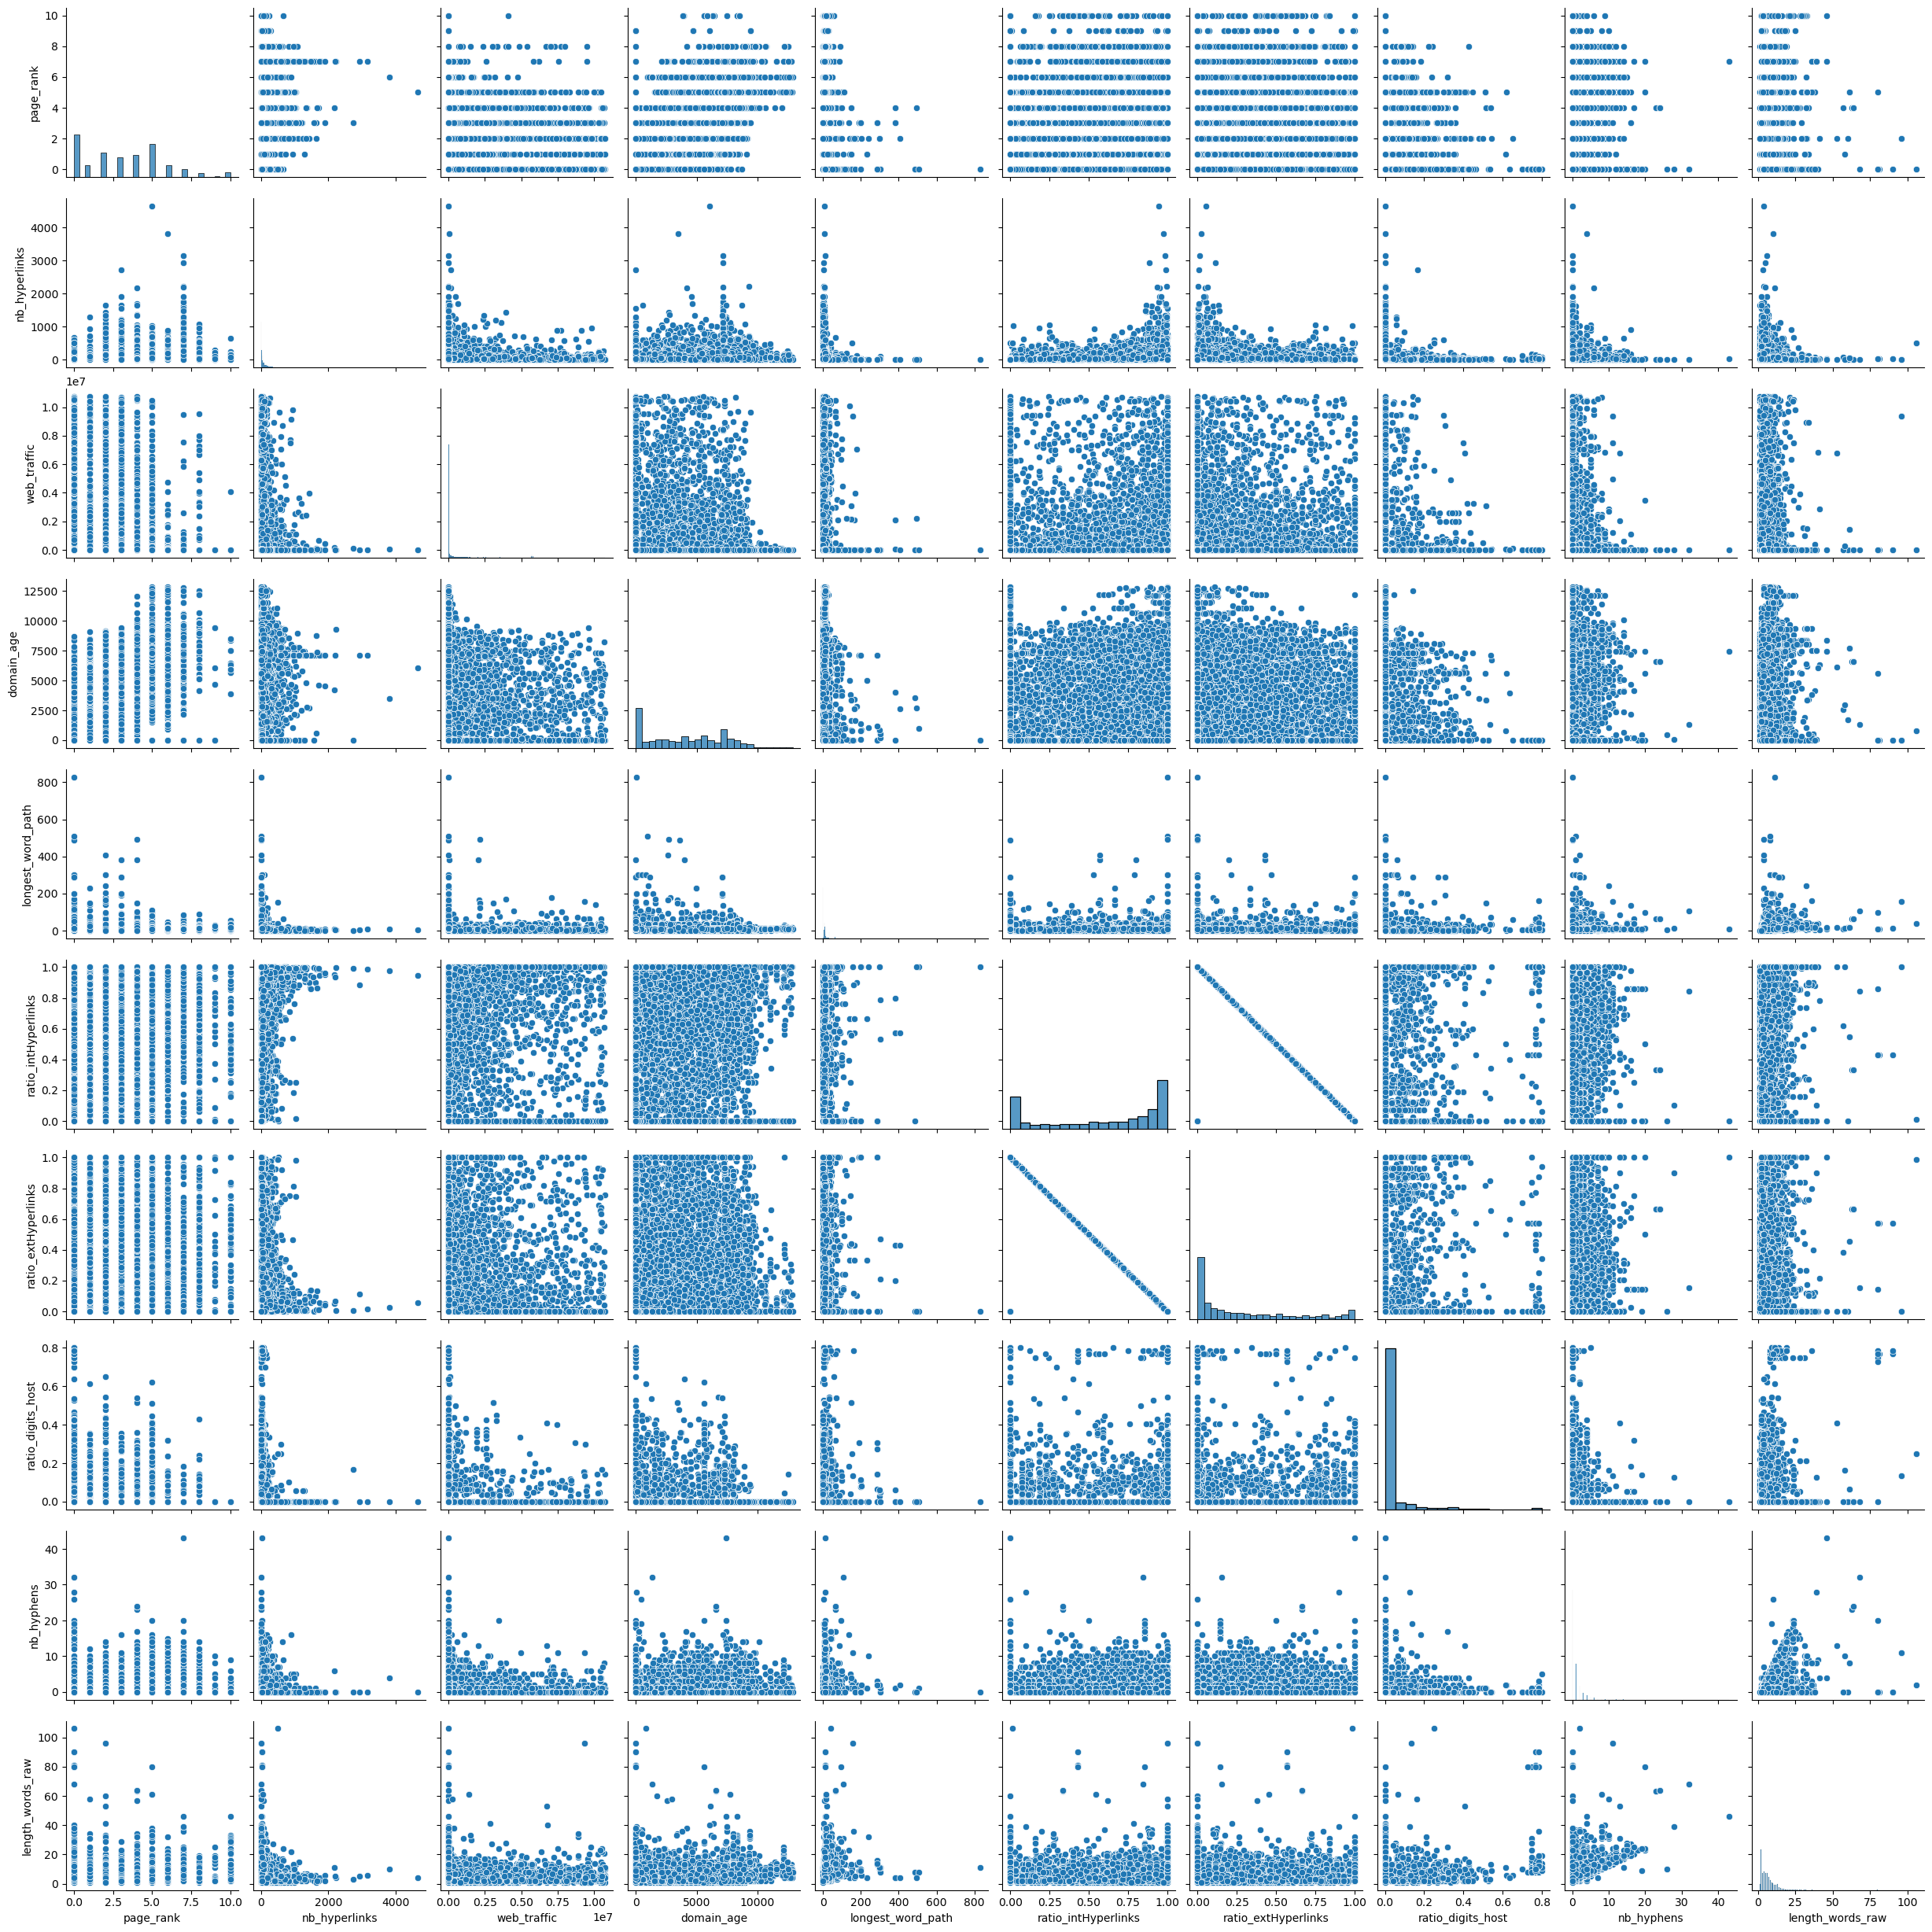

In [28]:
# Selecting the numerical columns for a pairwise plot
columns_for_pairplot = ['page_rank', 'nb_hyperlinks', 'web_traffic', 
                        'domain_age', 'longest_word_path', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 
                        'ratio_digits_host', 'nb_hyphens', 'length_words_raw']

# creating the plot
sns.pairplot(phishing_df_new[columns_for_pairplot])
plt.show()

## Normalization, Tokenization and Vectorization

In [29]:
# Normalize numerical columns
scaler = StandardScaler()
numerical_columns = [
    'page_rank', 'nb_hyperlinks', 'web_traffic', 'domain_age', 'longest_word_path', 
    'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_digits_host', 'nb_hyphens', 'length_words_raw', 
    'longest_words_raw', 'nb_dots', 'length_hostname', 'nb_slash', 'safe_anchor', 'shortest_word_host',
    'ratio_extRedirection', 'ratio_digits_url', 'shortest_word_path', 'avg_word_host', 'char_repeat', 
    'domain_registration_length', 'length_url', 'links_in_tags', 'avg_word_path', 'avg_words_raw'
]
phishing_df_new[numerical_columns] = scaler.fit_transform(phishing_df_new[numerical_columns])

In [30]:
phishing_df_new.head(10)

,url,length_url,length_hostname,nb_dots,nb_hyphens,nb_slash,nb_www,ratio_digits_url,ratio_digits_host,length_words_raw,...,ratio_extRedirection,links_in_tags,safe_anchor,domain_in_title,domain_registration_length,domain_age,web_traffic,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,-0.436327,-0.193964,0.379116,-0.477984,-0.685161,1,-0.594651,-0.267868,-0.400711,...,2.687711,0.674877,-0.948614,0,-0.549299,-1.307594,-0.429340,1,0.320974,0
1,http://shadetreetechnology.com/V4/validation/a...,0.287067,0.177207,-1.081136,-0.477984,0.377443,0,1.876053,-0.267868,-0.400711,...,-0.596511,1.156557,1.610785,1,-0.510022,0.548471,-0.429340,1,-0.467407,1
2,https://support-appleld.com.secureupdate.duila...,1.173224,2.682613,1.109242,0.001174,0.377443,0,1.092856,-0.267868,1.035010,...,-0.596511,1.156557,1.610785,1,-0.587348,-0.018839,2.491612,1,-1.255788,1
3,http://rgipt.ac.in,-0.779940,-0.936306,-0.351010,-0.477984,-1.216463,0,-0.594651,-0.267868,-0.939107,...,0.341838,1.156557,0.651011,1,-0.528433,-1.307594,-0.375359,0,-0.073217,0
4,http://www.iracing.com/tracks/gateway-motorspo...,-0.110800,-0.565135,-0.351010,0.480332,0.377443,1,-0.594651,-0.267868,-0.041781,...,1.419202,0.589875,-0.948614,0,-0.329595,1.323334,-0.424968,0,1.109355,0
5,http://appleid.apple.com-app.es/,-0.526752,0.270000,0.379116,0.001174,-0.685161,0,-0.594651,-0.267868,-0.400711,...,1.548287,1.156557,-0.948614,1,-0.604531,-1.307594,-0.429340,1,-1.255788,1
6,http://www.mutuo.it,-0.761855,-0.843513,-0.351010,-0.477984,-1.216463,1,-0.594651,-0.267868,-0.759642,...,-0.596511,-1.251844,1.610785,0,-0.395874,1.115460,-0.429340,0,-0.861598,0
7,http://www.shadetreetechnology.com/V4/validati...,0.359406,0.548379,-0.351010,-0.477984,0.377443,1,2.306677,-0.267868,-0.221246,...,-0.596511,1.156557,1.610785,1,-0.511249,0.548471,-0.429340,1,-0.467407,1
8,http://vamoaestudiarmedicina.blogspot.com/,-0.345903,1.197928,-0.351010,-0.477984,-0.685161,0,-0.594651,-0.267868,-0.759642,...,0.829780,-1.251844,-0.250596,1,-0.149168,1.041127,-0.429340,0,0.715164,0
9,https://parade.com/425836/joshwigler/the-amazi...,0.775358,-1.029099,-1.081136,4.313594,0.908745,0,0.266183,-0.267868,1.393940,...,0.129953,0.990461,0.539409,1,-0.447425,1.707225,-0.425946,0,0.715164,0


In [31]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Tokenization of the 'url' column
phishing_df_new['url_tokens'] = phishing_df_new['url'].apply(word_tokenize)

# Text Cleaning
phishing_df_new['cleaned_url'] = phishing_df_new['url_tokens'].apply(lambda tokens: ' '.join(tokens))

# Normalization (convert to lowercase)
phishing_df_new['cleaned_url'] = phishing_df_new['cleaned_url'].str.lower()

# Stopword Removal
stop_words = set(stopwords.words('english'))
phishing_df_new['cleaned_url'] = phishing_df_new['cleaned_url'].apply(lambda url: ' '.join(word for word in url.split() if word not in stop_words))

In [33]:
# Drop 'url' and 'url_tokens' columns
phishing_df_new = phishing_df_new.drop(['url', 'url_tokens'], axis=1)

In [34]:
phishing_df_new.head()

,length_url,length_hostname,nb_dots,nb_hyphens,nb_slash,nb_www,ratio_digits_url,ratio_digits_host,length_words_raw,char_repeat,...,links_in_tags,safe_anchor,domain_in_title,domain_registration_length,domain_age,web_traffic,google_index,page_rank,target,cleaned_url
0,-0.436327,-0.193964,0.379116,-0.477984,-0.685161,1,-0.594651,-0.267868,-0.400711,0.224909,...,0.674877,-0.948614,0,-0.549299,-1.307594,-0.429340,1,0.320974,0,http : //www.crestonwood.com/router.php
1,0.287067,0.177207,-1.081136,-0.477984,0.377443,0,1.876053,-0.267868,-0.400711,0.224909,...,1.156557,1.610785,1,-0.510022,0.548471,-0.429340,1,-0.467407,1,http : //shadetreetechnology.com/v4/validation...
2,1.173224,2.682613,1.109242,0.001174,0.377443,0,1.092856,-0.267868,1.035010,-0.194490,...,1.156557,1.610785,1,-0.587348,-0.018839,2.491612,1,-1.255788,1,https : //support-appleld.com.secureupdate.dui...
3,-0.779940,-0.936306,-0.351010,-0.477984,-1.216463,0,-0.594651,-0.267868,-0.939107,-0.613890,...,1.156557,0.651011,1,-0.528433,-1.307594,-0.375359,0,-0.073217,0,http : //rgipt.ac.in
4,-0.110800,-0.565135,-0.351010,0.480332,0.377443,1,-0.594651,-0.267868,-0.041781,0.015209,...,0.589875,-0.948614,0,-0.329595,1.323334,-0.424968,0,1.109355,0,http : //www.iracing.com/tracks/gateway-motors...


In [35]:
# Feature Extraction and Vectorization (using TF-IDF)
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  

# Fit and transform the cleaned URLs to create TF-IDF vectors
X_tfidf = tfidf_vectorizer.fit_transform(phishing_df_new['cleaned_url'])

# Convert the TF-IDF vectors to a DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF vectors with the original DataFrame
phishing_df_new = pd.concat([phishing_df_new, tfidf_df], axis=1)

# Drop the 'cleaned_url' column
phishing_df_new = phishing_df_new.drop('cleaned_url', axis=1)

In [36]:
phishing_df_new.head()

,length_url,length_hostname,nb_dots,nb_hyphens,nb_slash,nb_www,ratio_digits_url,ratio_digits_host,length_words_raw,char_repeat,...,yolasite,you,your,yourdictionary,youtube,yovcxm,yyy,za,zabor,zo
0,-0.436327,-0.193964,0.379116,-0.477984,-0.685161,1,-0.594651,-0.267868,-0.400711,0.224909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.287067,0.177207,-1.081136,-0.477984,0.377443,0,1.876053,-0.267868,-0.400711,0.224909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.173224,2.682613,1.109242,0.001174,0.377443,0,1.092856,-0.267868,1.035010,-0.194490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.779940,-0.936306,-0.351010,-0.477984,-1.216463,0,-0.594651,-0.267868,-0.939107,-0.613890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.110800,-0.565135,-0.351010,0.480332,0.377443,1,-0.594651,-0.267868,-0.041781,0.015209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
phishing_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Columns: 1031 entries, length_url to zo
dtypes: float64(1026), int64(5)
memory usage: 89.9 MB


In [38]:
phishing_df_new.shape

(11430, 1031)

In [39]:
# Assign features (X) and target variable (y)
X = phishing_df_new.drop(['target'], axis=1)  # Features are all columns except 'target'
y = phishing_df_new['target']  # Target variable is 'target'

## Splitting of Data

In [40]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9144, 1030)
y_train shape: (9144,)
X_test shape: (2286, 1030)
y_test shape: (2286,)


## ModeL Training

In [41]:
#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True,  
                fmt='.2f', xticklabels=['Legitimate', 'Phishing'], 
                yticklabels=['Legitimate', 'Phishing'], 
                cmap="crest")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show();

In [42]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
kfold

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

### Train Logistic Regression with Hyper-Parameter Tuning

In [43]:
# Define parameter grids for each model
C = np.logspace(-2, 1, 20)
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': C}

# Instantiate models
lr = LogisticRegression(max_iter=1000)  # high max_iter for convergence

# Use GridSearchCV with a larger k for k-fold cross-validation
grid_lr = GridSearchCV(lr, param_grid_lr, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

# Fit models
model_lr = grid_lr.fit(X_train, y_train)
lr_best = model_lr.best_estimator_

# Get best parameters and best scores
print("Logistic Regression:", model_lr.best_params_, model_lr.best_score_)

# View best hyperparameters
print('Best Penalty:', lr_best.get_params()['penalty'])
print('Best C:', lr_best.get_params()['C'])

# Best score
model_lr.best_score_

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Logistic Regression: {'C': 6.951927961775605, 'penalty': 'l2'} 0.9628176154775143
Best Penalty: l2
Best C: 6.951927961775605


0.9628176154775143

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1157
           1       0.97      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



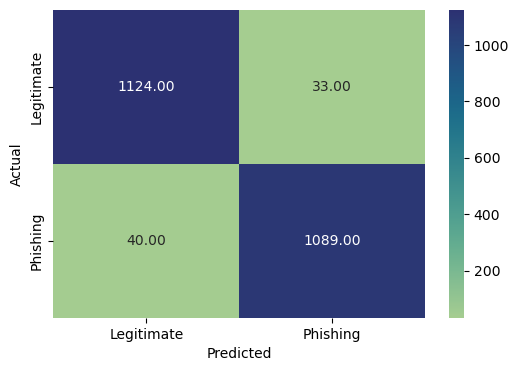

In [44]:
#checking the performance on the test dataset
y_pred_test_lrg = model_lr.predict(X_test)
metrics_score(y_test, y_pred_test_lrg)

### Train SVM with Hyper-Parameter Tuning

In [45]:
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': ['scale', 'auto'],          # Kernel coefficient for 'rbf' and 'poly' kernels
    'degree': [2, 3, 4]                  # Degree of the polynomial kernel
}

# Instantiate SVM classifier
svm = SVC()

# Use GridSearchCV for hyperparameter tuning
grid_svm = GridSearchCV(svm, param_grid_svm, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
model_svm = grid_svm.fit(X_train, y_train)

# Get the best estimator
svm_best = model_svm.best_estimator_

# Get best parameters and best score
print("Support Vector Machine:", model_svm.best_params_, model_svm.best_score_)

# View best hyperparameters
print('Best C:', svm_best.get_params()['C'])
print('Best kernel:', svm_best.get_params()['kernel'])
print('Best gamma:', svm_best.get_params()['gamma'])
print('Best degree:', svm_best.get_params()['degree'])

# Best score
print('Best score:', model_svm.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Support Vector Machine: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'} 0.965879040068874
Best C: 10
Best kernel: rbf
Best gamma: scale
Best degree: 2
Best score: 0.965879040068874


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1157
           1       0.97      0.97      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



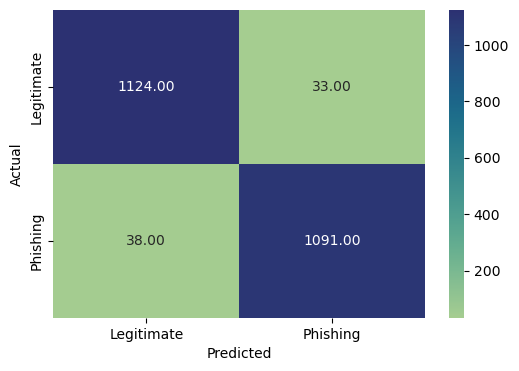

In [46]:
#checking the performance on the test dataset
y_pred_test_svm = model_svm.predict(X_test)
metrics_score(y_test, y_pred_test_svm)

### Train Random Forest with Hyper-Parameter Tuning

In [47]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}

# Instantiate Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_rf = GridSearchCV(rf, param_grid_rf, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
model_rft = grid_rf.fit(X_train, y_train)

# Get the best estimator
rf_best = model_rft.best_estimator_

# Get best parameters and best score
print("Random Forest:", model_rft.best_params_, model_rft.best_score_)

# View best hyperparameters
print('Best number of estimators:', rf_best.get_params()['n_estimators'])
print('Best max depth:', rf_best.get_params()['max_depth'])
print('Best min samples split:', rf_best.get_params()['min_samples_split'])
print('Best min samples leaf:', rf_best.get_params()['min_samples_leaf'])
print('Best bootstrap:', rf_best.get_params()['bootstrap'])

# Best score
print('Best score:', model_rft.best_score_)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} 0.9697070464301515
Best number of estimators: 300
Best max depth: None
Best min samples split: 5
Best min samples leaf: 1
Best bootstrap: False
Best score: 0.9697070464301515


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1157
           1       0.97      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



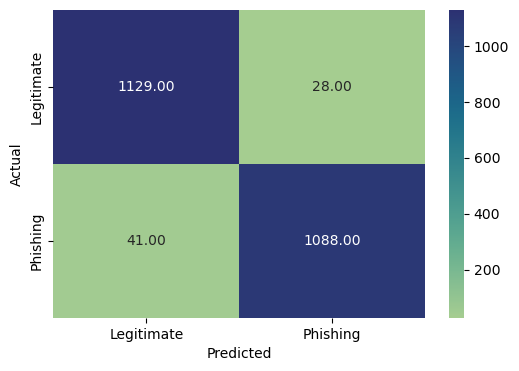

In [48]:
#checking the performance on the test dataset
y_pred_test_rft = model_rft.predict(X_test)
metrics_score(y_test, y_pred_test_rft)

### Train XGBoost with Hyper-Parameter Tuning

In [49]:
pip install xgboost

In [50]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Instantiate XGBoost classifier
xgb = XGBClassifier()

# Use GridSearchCV with a larger k for k-fold cross-validation
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

# Fit XGBoost model
model_xgb = grid_xgb.fit(X_train, y_train)
xgb_best = model_xgb.best_estimator_

# Get best parameters and best scores
print("XGBoost:", model_xgb.best_params_, model_xgb.best_score_)

# View best hyperparameters
print('Best learning rate:', xgb_best.get_params()['learning_rate'])
print('Best max depth:', xgb_best.get_params()['max_depth'])
print('Best n_estimators:', xgb_best.get_params()['n_estimators'])

# Best score
model_xgb.best_score_


Fitting 10 folds for each of 18 candidates, totalling 180 fits
XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300} 0.9702543315277825
Best learning rate: 0.1
Best max depth: 5
Best n_estimators: 300


0.9702543315277825

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1157
           1       0.97      0.97      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



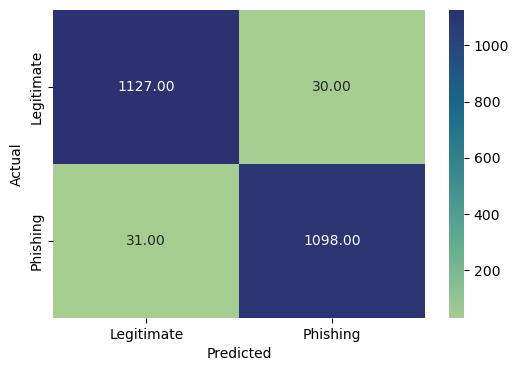

In [51]:
#checking the performance on the test dataset
y_pred_test_xgb = model_xgb.predict(X_test)
metrics_score(y_test, y_pred_test_xgb)

In [52]:
# function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Calculate the metrics for each model
models = [
    ("Logistic Reg", y_pred_test_lrg),
    ("SVM", y_pred_test_svm),
    ("Random Ft", y_pred_test_rft),
    ("XGboost", y_pred_test_xgb)
]

results = []
for model_name, y_pred in models:
    metrics = calculate_metrics(y_test, y_pred)
    results.append((model_name,) + metrics)

# put them in DataFrame
columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
model_comp = pd.DataFrame(results, columns=columns)

In [53]:
model_comp

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg,0.968066,0.970588,0.964570,0.967570
1,SVM,0.968941,0.970641,0.966342,0.968486
2,Random Ft,0.969816,0.974910,0.963685,0.969265
3,XGboost,0.973316,0.973404,0.972542,0.972973


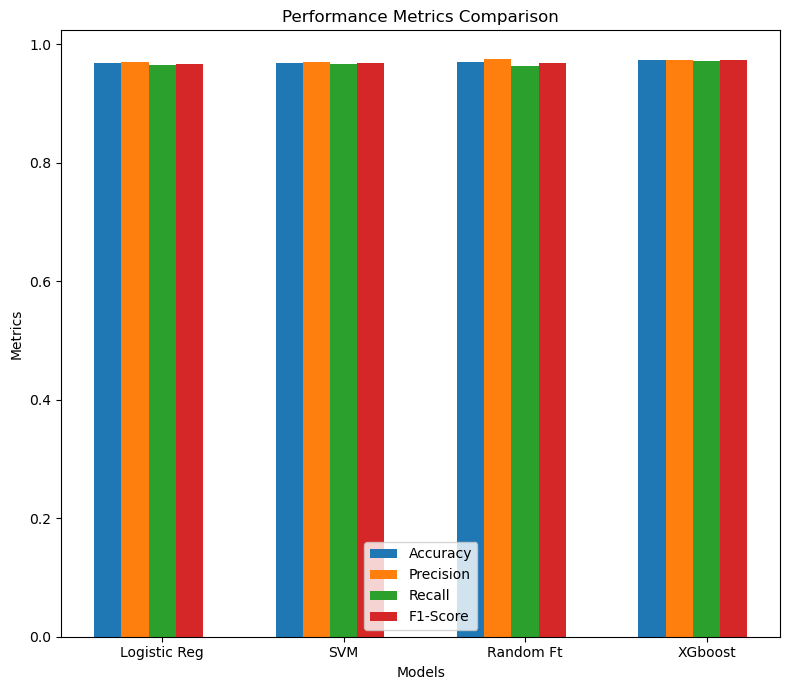

In [59]:
# Defining the models and metrics to plot from the dataframe (df)
models = model_comp['Model']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Set the width of the bars
bar_width = 0.15

# Set the position of the bars on the x-axis
r = np.arange(len(models))

# Create the bar plot
plt.figure(figsize=(8, 7))
for i, metric in enumerate(metrics):
    plt.bar(r + (i * bar_width), model_comp[metric], bar_width, label=metric)

# Add labels, title, and ticks
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Performance Metrics Comparison')
plt.xticks(r + bar_width * 2, models)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


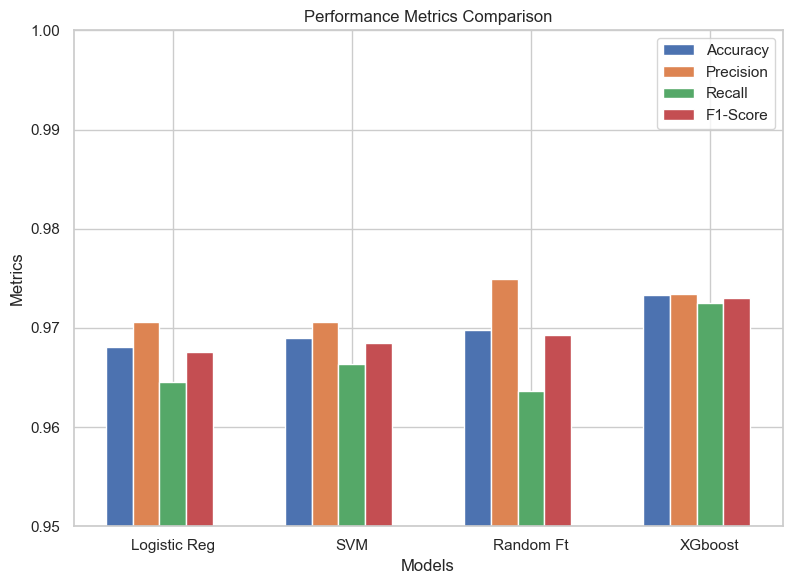

In [66]:
# Defining the models and metrics to plot from the dataframe (df)
models = model_comp['Model']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Set the width of the bars
bar_width = 0.15

# Set the position of the bars on the x-axis
r = np.arange(len(models))

# Create the bar plot
plt.figure(figsize=(8, 6))

for i, metric in enumerate(metrics):
    plt.bar(r + (i * bar_width), model_comp[metric], bar_width, label=metric)

# Add labels, title, and ticks
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Performance Metrics Comparison')
plt.xticks(r + (bar_width * len(metrics) / 2), models)  # Adjusting the x-ticks position
plt.legend()
plt.tight_layout()

# Adjust the scale of the y-axis
plt.ylim(0.95, 1.0)  # Set the limits of the y-axis

# Show plot
plt.show()


### Saving the Most Performed Model

In [67]:
import joblib

# Save the trained model
joblib.dump(xgb_best, 'xgboost_phishing_detection_model.pkl')

['xgboost_phishing_detection_model.pkl']